In [1]:
import pandas as pd

In [2]:
# The csv file is large, please download it first then read from local files
# if you insist in reading online, read it from:
# https://raw.githubusercontent.com/Jeff-HOU/bpi.2018/master/data/data_q2.csv
# ?token=AilEXVc0O5KlZviHuRGCT7A4Luhovbleks5a8BUjwA%3D%3D

df_q2 = pd.read_csv('F:\\Competitions\\BPI\\data\\data_q2.csv')

In [3]:
bools = df_q2.select_dtypes(include='bool').columns.tolist()
bool_to_int = df_q2.loc[:, bools].astype(int)
df_q2 = df_q2.drop(columns=bools+['Unnamed: 0', 'case'])
df_q2 = pd.concat([df_q2, bool_to_int], axis=1)
df_q2.columns = df_q2.columns.str.replace('\s+', '_')

In [4]:
penalties = ['penalty_B3', 'penalty_B4', 'penalty_B5', 'penalty_B5F', 'penalty_B6', 'penalty_B16', 'penalty_BGK',
             'penalty_BGKV', 'penalty_C16', 'penalty_JLP3', 'penalty_V5']
attribs = ['number_parcels', 'area', 'young_farmer', 'small_farmer', 'redistribution']
depts = df_q2['department'].unique()

In [5]:
df_q2_d_list = []
for d in depts:
    df_q2_d_list.append([d, df_q2.loc[df_q2['department'] == d].drop(columns='department')])

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score,\
                            confusion_matrix, precision_recall_curve, roc_curve, auc, log_loss

import numpy as np
np.seterr(all='raise')
import warnings

results_list = []

for k in range(0, len(depts)):
    results = pd.DataFrame(index=['Intercept'] + attribs + ['accuracy'])
    df_q2_d = df_q2_d_list[k][1]
    # print("\nFor department", df_q2_d_list[k][0])
    X = df_q2_d[attribs]
    for i in range(0, len(penalties)):
        # print("\n{} cross-validation results:".format(penalties[i]))
        y = df_q2_d[penalties[i]]
        if len(y.unique()) == 1: continue
        while True:
            X_train, X_test, y_train, y_test = train_test_split(X, y)
            if len(y_train.unique()) > 1: break
        if len(y_test.unique()) == 1:
            # print("y_test only contains 0.")
            results = pd.concat([results, pd.DataFrame({penalties[i]: np.full(2+len(attribs), np.nan)},
                                                       index=['Intercept'] + attribs + ['accuracy'])], axis=1)
            continue
        log_reg = LogisticRegression()
        log_reg.fit(X_train, y_train)
        y_pred = log_reg.predict(X_test)
        y_pred_proba = log_reg.predict_proba(X_test)[:, 1]
        [fpr, tpr, thr] = roc_curve(y_test, y_pred_proba)
        # print("Intercept: {}; Coefficients: {}".format(log_reg.intercept_, log_reg.coef_))
        results = pd.concat([results, pd.DataFrame({penalties[i]: np.concatenate((log_reg.intercept_, log_reg.coef_[0], 
                                                                                 [accuracy_score(y_test, y_pred)]))}, 
                                                   index=['Intercept'] + attribs + ['accuracy'])], axis=1)
#         try:
#             with warnings.catch_warnings():
#                 warnings.simplefilter('error')
#                 # print("{} accuracy is {:.3f}".format(log_reg.__class__.__name__, accuracy_score(y_test, y_pred)))
#                 # print("{} log_loss is {:.3f}".format(log_reg.__class__.__name__, log_loss(y_test, y_pred_proba)))
#                 # print("{} auc is {:.3f}".format(log_reg.__class__.__name__, auc(fpr, tpr)))
#         except FloatingPointError as e:
#             print(penalties[i], e)
    results_list.append(results)

In [7]:
for k in range(0, len(depts)):
    display(results_list[k])

,penalty_B3,penalty_B4,penalty_B5,penalty_B5F,penalty_B6,penalty_B16,penalty_BGK,penalty_BGKV,penalty_C16,penalty_JLP3
Intercept,-2.025610,-3.670914,-3.014148,NaN,-2.970233,-2.991959,-3.036319,NaN,NaN,-3.957779
number_parcels,0.061416,0.013349,0.132123,NaN,0.092948,0.012006,-0.006010,NaN,NaN,-0.018706
area,-0.037983,0.008238,-0.063148,NaN,-0.060781,-0.029120,0.004416,NaN,NaN,0.007090
young_farmer,0.223775,0.375919,-0.177901,NaN,0.422212,0.219635,-0.221901,NaN,NaN,1.928153
small_farmer,0.078246,-0.327105,-0.244557,NaN,-0.210777,-0.903113,0.636468,NaN,NaN,-0.237886
redistribution,-1.525241,-3.342078,-2.186279,NaN,-2.141640,-2.218662,-2.363289,NaN,NaN,-3.563743
accuracy,0.982994,0.996963,0.996660,NaN,0.997267,0.997571,0.997571,NaN,NaN,0.998785


,penalty_B3,penalty_B4,penalty_B5,penalty_B5F,penalty_B6,penalty_B16,penalty_BGK,penalty_BGKV,penalty_C16,penalty_JLP3
Intercept,-2.121109,-3.475357,-2.748629,-2.666273,-2.739504,-2.704081,-2.206641,NaN,NaN,NaN
number_parcels,0.090971,0.043725,0.039050,0.188521,0.115004,0.141007,0.009955,NaN,NaN,NaN
area,-0.034825,0.003044,-0.009774,-0.209814,-0.051596,-0.077480,-0.001517,NaN,NaN,NaN
young_farmer,-0.452307,-0.956768,-0.898401,-0.205761,-0.554910,0.067289,0.288883,NaN,NaN,NaN
small_farmer,-0.853787,-0.288433,0.973755,-0.659094,-0.259644,0.031512,0.158759,NaN,NaN,NaN
redistribution,-1.546784,-3.250603,-2.263697,-2.445786,-2.426003,-2.312723,-2.405068,NaN,NaN,NaN
accuracy,0.970056,0.994429,0.995125,0.999304,0.996518,0.997214,0.983983,NaN,NaN,NaN


,penalty_B3,penalty_B4,penalty_B5,penalty_B5F,penalty_B6,penalty_B16,penalty_BGK,penalty_BGKV,penalty_C16,penalty_JLP3
Intercept,-2.058629,-3.968606,-2.958573,NaN,-2.905756,-3.225577,-3.133171,NaN,NaN,NaN
number_parcels,0.038638,0.026305,0.066170,NaN,0.024223,0.050090,0.048560,NaN,NaN,NaN
area,-0.025326,0.005556,-0.047174,NaN,-0.033606,-0.030055,-0.016068,NaN,NaN,NaN
young_farmer,0.103814,0.136444,-0.277973,NaN,-0.382433,0.198267,0.274251,NaN,NaN,NaN
small_farmer,-0.580844,-0.336097,-0.595064,NaN,-0.707691,-0.317017,-1.051008,NaN,NaN,NaN
redistribution,-1.570965,-3.251824,-2.244271,NaN,-2.020996,-2.434257,-2.092162,NaN,NaN,NaN
accuracy,0.981525,0.997947,0.997654,NaN,0.999120,0.997361,0.994428,NaN,NaN,NaN


,penalty_B3,penalty_B4,penalty_B5,penalty_B5F,penalty_B6,penalty_B16,penalty_BGK,penalty_BGKV,penalty_C16,penalty_V5
Intercept,-2.040873,-3.457327,-2.571368,NaN,-2.838096,-2.661489,-2.940314,NaN,NaN,NaN
number_parcels,0.031143,0.031468,0.071577,NaN,0.120141,0.083671,0.025398,NaN,NaN,NaN
area,-0.016526,0.003329,-0.022730,NaN,-0.060624,-0.063013,-0.001758,NaN,NaN,NaN
young_farmer,-0.005497,0.059663,0.849706,NaN,0.251699,-0.284362,0.272633,NaN,NaN,NaN
small_farmer,-0.214645,-0.458244,-0.838304,NaN,-0.278945,-0.340259,0.569307,NaN,NaN,NaN
redistribution,-1.380396,-3.013982,-2.951021,NaN,-2.192748,-2.164557,-2.202530,NaN,NaN,NaN
accuracy,0.976546,0.993603,0.995736,NaN,0.997868,0.996091,0.993603,NaN,NaN,NaN


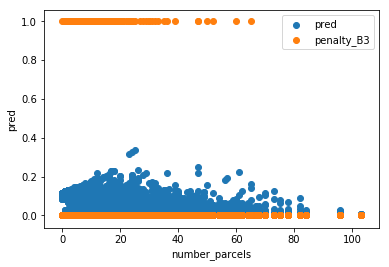

In [9]:
import math
import matplotlib.pyplot as plt

def logit(dec_func):
    return 1/(1+math.exp(-(dec_func)))

k = 0 # index of dept
i = 0 # index of penalty
df_q2_d = df_q2_d_list[k][1]
coef = results_list[k].iloc[:, i]
if math.isnan(coef[0]):
    print(penalties[i], "NaN.")
    raise KeyboardInterrupt

df_q2_d['dec_func'] = coef[0] + df_q2_d.iloc[:,0]*coef[1] + df_q2_d.iloc[:,1]*coef[2]
df_q2_d['pred'] = df_q2_d['dec_func'].apply(logit)

plt.scatter(df_q2_d['number_parcels'], df_q2_d['pred'])
plt.scatter(df_q2_d['number_parcels'], df_q2_d[penalties[i]])
plt.xlabel('number_parcels')
plt.ylabel('pred')
plt.legend()
plt.show()

In [ ]:
# With smf, most cases have convergence problems. Not sure about the math here.

# import statsmodels.formula.api as smf

# import os, sys
# class HiddenPrints:
#     def __enter__(self):
#         self._original_stdout = sys.stdout
#         sys.stdout = None

#     def __exit__(self, exc_type, exc_val, exc_tb):
#         sys.stdout = self._original_stdout

# results_smf_list = []
# for k in range(0, len(depts)):
#     results_smf = pd.DataFrame(index=['Intercept'] + attribs + ['prsquared'])
#     df_q2_d = df_q2_d_list[k][1]
#     for i in range(0, len(penalties)):
#         with HiddenPrints():
#             try:
#                 print(penalties[i])
#                 with warnings.catch_warnings():
#                     warnings.simplefilter('error')
#                     log_model = smf.logit(formula= penalties[i] + ' ~ ' + ' + '.join(attribs), data=df_q2_d).fit()
#                     results_smf = pd.concat([results_smf,
#                                       pd.DataFrame({penalties[i]: log_model.params.append(pd.Series(log_model.prsquared,
#                                                                                               index=['prsquared']))})],axis=1)
#             except:
#                 results_smf = pd.concat([results_smf, pd.DataFrame({penalties[i]: np.full(2+len(attribs), np.nan)}, 
#                                                                index=['Intercept'] + attribs + ['prsquared'])], axis=1)
#     results_smf_list.append(results_smf)

In [ ]:
# None of the 5 attributes can be left out, according to RFECV

# from sklearn.feature_selection import RFE, RFECV

# for k in range(0, len(depts)):
#     df_q2_d = df_q2_d_list[k][1]
#     print("\nFor department", df_q2_d_list[k][0])
#     X = df_q2_d[attribs]
#     for i in range(0, len(penalties)):
#         y = df_q2_d[penalties[i]]
#         try:
#             rfecv = RFECV(estimator=LogisticRegression(), step=1, cv=10, scoring='accuracy')
#             rfecv.fit(X, y)
#         except ValueError as err:
#             print('Training set contains only 0.')
#             continue

#         print("Optimal number of features: {}".format(rfecv.n_features_))
#         print('Selected features: {}'.format(list(X.columns[rfecv.support_])))

# # Plot number of features VS. cross-validation scores
# plt.figure(figsize=(10,6))
# plt.xlabel("Number of features selected")
# plt.ylabel("Cross validation score (nb of correct classifications)")
# plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
# plt.show()

In [ ]:
# old linear version

# for k in range(0, len(depts)):
#     df_q2_d = df_q2_d_list[k][1]
#     print("\nFor department", df_q2_d_list[k][0])
# #     X = df_q2_d[attribs]
#     for i in range(0, len(penalties)):
# #         y = df_q2_d[penalties[i]]

# #         X_train, X_test, y_train, y_test = train_test_split(X, y)
# #         train = pd.concat([y_train, X_train], axis=1)
#         lm = smf.ols(formula= penalties[i] + ' ~ ' + ' + '.join(attribs),
#                        data=df_q2_d).fit()

#         if not lm.centered_tss:
#             print(penalties[i], ': TSS = 0, same value for all obs.')
#         elif lm.rsquared_adj > 0.5:
#             print(penalties[i])